In [25]:
import tensorflow as tf
import numpy as np
import gym
import datetime
from tqdm import tqdm_notebook
import random
import itertools
from go_ai import rl_utils, metrics, mcts
import matplotlib.pyplot as plt
import collections
from functools import reduce

In [26]:
from absl import logging
logging._warn_preinit_stderr = 0
logging.set_verbosity(logging.INFO)

# Hyperparameters

In [27]:
BOARD_SIZE = 7

In [28]:
ITERATIONS = 256
EPISODES_PER_ITERATION = 32
MAX_STEPS = 2 * BOARD_SIZE**2
BATCH_SIZE = 32

In [29]:
NUM_EVAL_GAMES = 32

In [30]:
LEARNING_RATE = 1e-3
BETA_1 = 0.9

In [31]:
MC_SIMS = 0
TEMP_THRESHOLD = 4

In [32]:
LOAD_SAVED_MODELS = True
WEIGHTS_DIR = 'model_weights/'
LEVEL_PATHS = [None]

In [33]:
EXPLORE_WEIGHT = 0.1
EXPLORE_DECAY = 0.9
MIN_EXPLORE = 0.1
CRITIC_GAMMA = 1/2

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [34]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE, reward_method='heuristic')

# Machine Learning Models

In [35]:
ACTOR_CRITIC_PATH = WEIGHTS_DIR + 'tmp/actor_critic.h5'

In [36]:
actor_critic = rl_utils.make_actor_critic(BOARD_SIZE, 'val_net', 'tanh')

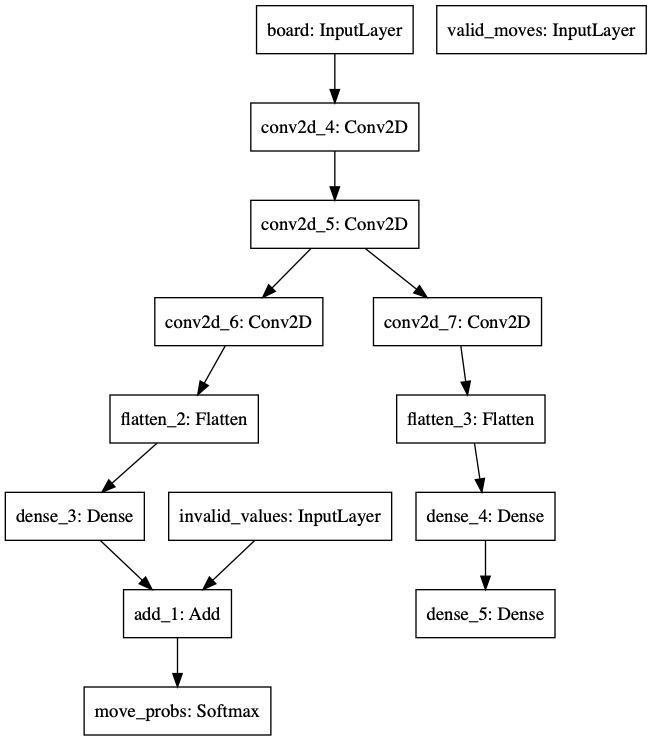

In [37]:
tf.keras.utils.plot_model(actor_critic)

In [38]:
actor_critic.summary()

Model: "actor_critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 6)]    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 32)     1760        board[0][0]                      
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 16)     4624        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 2)      34          conv2d_5[0][0]                   
_______________________________________________________________________________________

In [39]:
opponent = tf.keras.models.clone_model(actor_critic)

In [40]:
if LOAD_SAVED_MODELS:
    actor_critic.load_weights(ACTOR_CRITIC_PATH)
    opponent.load_weights(ACTOR_CRITIC_PATH)
    logging.info("Loaded saved models")

I0915 18:51:59.866234 4674176448 <ipython-input-40-1004a61459a1>:4] Loaded saved models


# Metrics and Tensorboard

In [41]:
!rm -rf ./logs/

Metrics

In [42]:
tb_metrics = {}
for metric_key in ['val_loss', 'overall_loss', 'win_rate', 'num_steps', 'move_loss']:
    tb_metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)
    
# for metric_key in ['explore_weight', 'explore_loss']:
#     metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)

tb_metrics['pred_win_acc'] = tf.keras.metrics.Accuracy()

Tensorboard

In [43]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/actor_critic/{}/main'.format(current_time)
summary_writer = tf.summary.create_file_writer(log_dir)    

# Demo Trajectories

Symmetries

In [44]:
mct_forward = rl_utils.make_mcts_forward(actor_critic)

In [45]:
mem = []
state = go_env.reset()
action = (1,2)
action_1d = BOARD_SIZE * action[0] + action[1]
next_state, reward, done, info = go_env.step(action)
mct = mcts.MCTree(state, mct_forward)
mc_pi = mct.get_action_probs(max_num_searches=MC_SIMS, temp=1)
rl_utils.add_to_replay_mem(mem, state, action_1d, next_state, reward, done, 0, mc_pi)

In [46]:
if False:
    plt.show(metrics.state_responses(actor_critic, mem))

Plot a whole game trajectory

In [47]:
%time traj, _ = rl_utils.self_play(go_env, policy=actor_critic, max_steps=MAX_STEPS, mc_sims=MC_SIMS, 
                             temp_threshold=TEMP_THRESHOLD, get_symmetries=False)

IndentationError: unexpected indent (<ipython-input-47-137f390debe2>, line 2)

KeyboardInterrupt: 

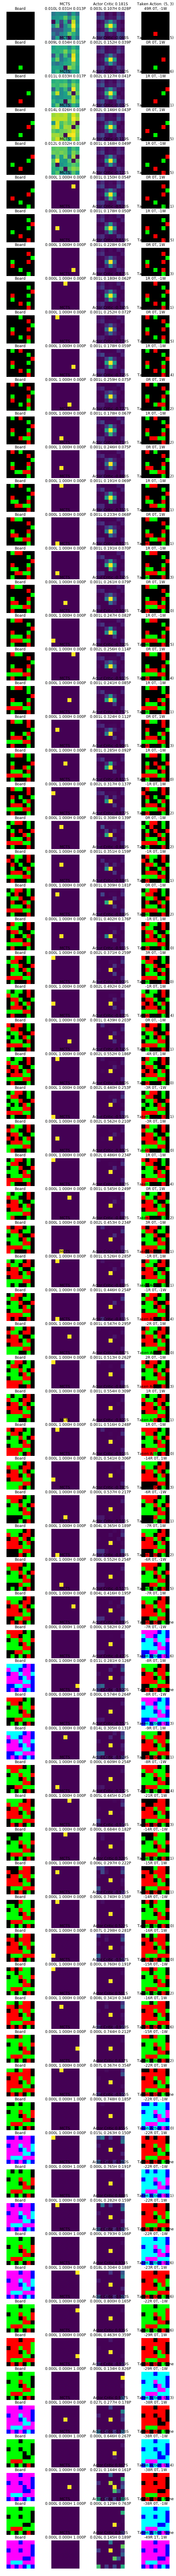

In [24]:
fig = metrics.state_responses(actor_critic, traj)
fig.savefig('logs/a_trajectory.png')
plt.close()

### Helper Functions

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
actor_critic_opt = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1)

In [ ]:
def update_actor_critic(batched_mem, iteration, metrics):
    """
    Optimizes the actor over the whole replay memory
    """ 
    explore_weight = max(EXPLORE_WEIGHT * (EXPLORE_DECAY**iteration), MIN_EXPLORE)
    for states, actions, next_states, rewards, terminals, wins, mcts_action_probs in tqdm_notebook(batched_mem, 
                                                                                desc='Updating actor_critic', 
                                                                                leave=False):
        batch_size = states.shape[0]
        
        # Actor
        valid_moves = rl_utils.get_valid_moves(states)
        
        # Critic
        wins = wins[:,np.newaxis]
        next_move_probs, next_move_vals = rl_utils.forward_pass(next_states, actor_critic, training=True)
        targets = rewards + CRITIC_GAMMA * tf.math.reduce_sum(next_move_probs * next_move_vals, axis=1, keepdims=True)
        with tf.GradientTape() as tape:    
            move_prob_distrs, state_vals = rl_utils.forward_pass(states, actor_critic, training=True)
            
            # Actor
            move_loss = binary_cross_entropy(mcts_action_probs, move_prob_distrs)
            
            # Critic
            assert state_vals.shape == wins.shape
            val_loss = tf.reduce_mean((wins - state_vals)**2)
            
            overall_loss = val_loss + move_loss
        
        tb_metrics['move_loss'].update_state(move_loss)
        tb_metrics['val_loss'].update_state(val_loss)
        
        tb_metrics['overall_loss'].update_state(overall_loss)
        
        wins_01 = np.copy(wins)
        wins_01[wins_01 < 0] = 0
        tb_metrics['pred_win_acc'].update_state(wins_01, state_vals > 0)
        
        # compute and apply gradients
        gradients = tape.gradient(overall_loss, actor_critic.trainable_variables)
        actor_critic_opt.apply_gradients(zip(gradients, actor_critic.trainable_variables))

# Train

In [ ]:
replay_mem = []

In [ ]:
for iteration in tqdm_notebook(range(ITERATIONS), desc='Iteration'):
    # Train
    logging.debug("Playing games")
    episode_pbar = tqdm_notebook(range(EPISODES_PER_ITERATION), desc='Episode', leave=False)
    for episode in episode_pbar:
        trajectory, num_steps = rl_utils.self_play(go_env, policy=actor_critic, max_steps=MAX_STEPS, mc_sims=MC_SIMS,
                                                   temp_threshold=TEMP_THRESHOLD)
        replay_mem.extend(trajectory)
        tb_metrics['num_steps'].update_state(num_steps)
    
    # Save the first and last events for logging to tensorboard
    first_event, last_event = replay_mem[0], replay_mem[-1]
    
    # Update the models (also shuffles memory)
    logging.debug("Updating model...")
    random.shuffle(replay_mem)
    np_data = rl_utils.replay_mem_to_numpy(replay_mem)
    batched_np_data = [np.array_split(datum, len(replay_mem) // BATCH_SIZE) for datum in np_data]
    batched_mem = list(zip(*batched_np_data))
    update_actor_critic(batched_mem, iteration, metrics)
    
    # Evaluate against previous model
    win_rate = metrics.evaluate(go_env, actor_critic, opponent, max_steps=MAX_STEPS, 
                                num_games=NUM_EVAL_GAMES, mc_sims=MC_SIMS, temp_threshold=TEMP_THRESHOLD)
    tb_metrics['win_rate'](win_rate)
    
    if win_rate > 0.6:
        actor_critic.save_weights(ACTOR_CRITIC_PATH)
        opponent.load_weights(ACTOR_CRITIC_PATH)
        logging.info("{:.1f}% Accepted new model".format(100*win_rate))
    else:
        logging.info("{:.1f}% Rejected new model".format(100*win_rate))
    
    # Log results and resets the metrics
    logging.debug("Logging metrics to tensorboard...")
    
    metrics.log_to_tensorboard(summary_writer, tb_metrics, iteration, [first_event] + replay_mem[:6] + [last_event], 
                               actor_critic)

    # Reset memory
    replay_mem.clear()

# Evaluate

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE)
rl_utils.play_against(opponent, go_env, MC_SIMS, 0)